# Создание классов датасетов российских дорожных знаков (RTSD)

In [1]:
import numpy as np
import pandas as pd
import os
import json
from PIL import Image
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline
import seaborn as sns
import random
import cv2
# from pycocotools.coco import COCO

import warnings
warnings.filterwarnings('ignore')

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms as transforms

In [2]:
# !pip install kaggle
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !kaggle datasets download -d watchman/rtsd-dataset
# !unzip rtsd-dataset.zip
# !rm rtsd-dataset.zip
# !cp -r rtsd-frames/rtsd-frames/ .
# !rm -r rtsd-frames/rtsd-frames/

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

### DATASET DETECT

In [4]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 5
batch_size = 6
classes = 2
device

'cpu'

#### pandas

In [5]:
# функция загрузки датасета в pd
def dataset(path, name_f):
  
  with open(os.path.join(path, name_f), 'r') as f:
    anno = json.load(f)

    obj1 = anno.get('images')
    df1 = pd.json_normalize(obj1)
    obj2 = anno.get('annotations')
    df2 = pd.json_normalize(obj2)
    obj3 = anno.get('categories')
    df3 = pd.json_normalize(obj3)
    t = df2.merge(df3.set_index('id'), left_on='category_id',right_index=True)
    df= t.merge(df1.set_index('id'), left_on='image_id',right_index=True)
  
  return df

In [6]:
df_train_anno = dataset('.', 'train_anno.json')
df_val_anno = dataset('.', 'val_anno.json')
df_train_anno_reduced = dataset('.', 'train_anno_reduced.json')

In [7]:
# Приведем все знаки к одному классу
df_train_anno_1 = df_train_anno.copy()
df_train_anno_1['category_id'] = 1

df_val_anno_1 = df_val_anno.copy()
df_val_anno_1['category_id'] = 1

df_train_anno_reduced_1 = df_train_anno_reduced.copy()
df_train_anno_reduced_1['category_id'] = 1

In [8]:
# разделим df_train_anno на train / test
random_state=33
df_test_1 = df_train_anno_1.sample(frac = 0.2, random_state=random_state)
df_train_1 = df_train_anno_1.drop(df_test_1.index)

In [9]:
class RTSD_dataset_my(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        self.df = self.df.groupby('file_name', as_index=False).agg(list)
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        img = Image.open(os.path.join(self.path_img, name_img))
      
        boxes = []
        for b in self.df.loc[index,'bbox']:
            bb = [b[0], b[1], b[0] + b[2], b[1] + b[3]]
            boxes.append(bb)   

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.Tensor(self.df.loc[index, 'category_id']).to(torch.int64)
        img_id = torch.tensor([self.df.loc[index, 'image_id'][0]])
        
        areas = []
        for i in self.df.loc[index,'area']:
            areas.append(self.df.loc[index,'area'])
        areas = torch.as_tensor(areas[0], dtype=torch.float32)
       
        iscrowd = torch.zeros(len(self.df.loc[index,'iscrowd'])).to(torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
        
        img = img / 255

        return img, my_annotation

    def __len__(self):
        
        return self.df.shape[0]

In [10]:
# In my case, just added ToTensor
def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)

In [11]:
def get_transform_a():
             return transforms.Compose([transforms.Resize((512,512)),
                    transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(), transforms.ToTensor()]),
                    transforms.Compose([transforms.ColorJitter(), transforms.ToTensor()]),
                    transforms.Compose([transforms.RandomResizedCrop((512,512)),transforms.ToTensor()]),
                    transforms.Compose([transforms.ToTensor(),transforms.RandomErasing()])])])

In [12]:
# collate_fn needs for batch
def collate_fn(batch):
    return tuple(zip(*batch))

In [13]:
df1 = RTSD_dataset_my('./', df_train_anno_reduced_1,transforms=get_transform())
df11 = RTSD_dataset_my('./', df_val_anno_1,transforms=get_transform())

In [14]:
df2 = RTSD_dataset_my('./', df_train_anno_reduced_1,transforms=get_transform_a())
df22 = RTSD_dataset_my('./', df_val_anno_1,transforms=get_transform_a())

In [15]:
data_loader_train1 = torch.utils.data.DataLoader(df1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_train2 = torch.utils.data.DataLoader(df2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

data_loader_val1 = torch.utils.data.DataLoader(df11,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val2 = torch.utils.data.DataLoader(df22,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

#### COCO

In [12]:
def anno_1_class(anno_file):
 
    with open(os.path.join('.', anno_file), 'r') as read_file:
        anno_json = json.load(read_file)
    read_file.close()

    for i in range(len(anno_json['annotations'])):
        anno_json['annotations'][i]['category_id'] = 1    
    
    anno_json['categories'] = [{'id': 1, 'name': 'sign'}]
    
    anno_file_new = anno_file.split('.')[0] + '_1.json'
    
    with open(os.path.join('.', anno_file_new), 'w') as f:
        json.dump(anno_json, f)
    f.close()

    return anno_json

In [ ]:
def anno_train_test_split(anno_file):
    
    with open(os.path.join('.', anno_file), 'r') as file1:
        anno_json1 = json.load(file1)
    
    x1 = int(len(anno_json1['images'])*0.2)
    file_train = anno_file.split('.')[0] + '_train.json'
          
    del anno_json1['images'][:x1]
    
    with open(os.path.join('.', file_train), 'w') as f1:
                        json.dump(anno_json1, f1)
    
    
    with open(os.path.join('.', anno_file), 'r') as file2:
            anno_json2 = json.load(file2)
    
    
    x2 = int(len(anno_json2['images'])*0.2)
    y2 = int(len(anno_json2['images']))
    
    file_test= anno_file.split('.')[0] + '_test.json'
    
    del anno_json2['images'][x2:y2]
            
    with open(os.path.join('.', file_test), 'w') as f2:
                        json.dump(anno_json2, f2)  
            
    return anno_json1, anno_json2

In [ ]:
train_anno_1 = anno_1_class('train_anno.json')
val_anno_1 = anno_1_class('val_anno.json')
train_anno_reduced_1 = anno_1_class('train_anno_reduced.json')

In [ ]:
train1, test1 = anno_train_test_split('train_anno_1.json')

In [16]:
class RTSD_dataset_coco(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        # Own coco file
        coco = self.coco
        # Image ID
        img_id = self.ids[index]
        # List: get annotation id from coco
        ann_ids = coco.getAnnIds(imgIds=img_id)
        # Dictionary: target coco_annotation file for an image
        coco_annotation = coco.loadAnns(ann_ids)
        # path for input image
        path = coco.loadImgs(img_id)[0]["file_name"]
        # open the input image
        img = Image.open(os.path.join(self.root, path))
    
        
        # number of objects in the image
        num_objs = len(coco_annotation)

        # Bounding boxes for objects
        # In coco format, bbox = [xmin, ymin, width, height]
        # In pytorch, the input should be [xmin, ymin, xmax, ymax]
        boxes = []
        for i in range(num_objs):
            xmin = coco_annotation[i]["bbox"][0]
            ymin = coco_annotation[i]["bbox"][1]
            xmax = xmin + coco_annotation[i]["bbox"][2]
            ymax = ymin + coco_annotation[i]["bbox"][3]
            boxes.append([xmin, ymin, xmax, ymax])
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Labels (In my case, I only one class: target class or background)
        labels = torch.ones((num_objs,), dtype=torch.int64)
        # Tensorise img_id
        img_id = torch.tensor([img_id])
        # Size of bbox (Rectangular)
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]["area"])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        # Iscrowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Annotation is in dictionary format
        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd

        if self.transforms is not None:
            img = self.transforms(img)
            
        img = img / 255

    
        return img, my_annotation
    
    def __len__(self):
        return len(self.ids)

In [ ]:
root = '.'
annotation = './train_anno_reduced_1.json'

# create own Dataset
df_1 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform()
                          )
# df_1.__getitem__(100)

In [ ]:
root = '.'
annotation = './val_anno_1.json'

# create own Dataset
df_11 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform()
                          )
# df_11.__getitem__(100)

In [ ]:
root = '.'
annotation = './train_anno_reduced_1.json'

# create own Dataset
df_2 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform_a()
                          )
# df_2.__getitem__(100)

In [ ]:
root = '.'
annotation = './val_anno_1.json'

# create own Dataset
df_22 = RTSD_dataset_coco(root=root,
                          annotation=annotation,
                          transforms=get_transform()
                          )
# df_22.__getitem__(100)

In [ ]:
data_loader_train_1 = torch.utils.data.DataLoader(df_1,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_train_2 = torch.utils.data.DataLoader(df_2,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          collate_fn=collate_fn)

data_loader_val_1 = torch.utils.data.DataLoader(df_11,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn,
                                          drop_last = True)

data_loader_val_2 = torch.utils.data.DataLoader(df_22,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          collate_fn=collate_fn)

#### Визуализация аргументации данных

In [17]:
def show_tranformed_image(train_loader):
    fig, ax = plt.subplots()
    fig.set_size_inches(18, 10)
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
            sample = sample * 255
            ax.imshow(sample)
            for box in boxes:
                      x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
                      rect = patches.Rectangle((x, y),
                                              width, height,
                                              fc ='none', 
                                              ec ='g',
                                              lw = 2)
                      ax.add_patch(rect)
            plt.axis('off')
            plt.show()

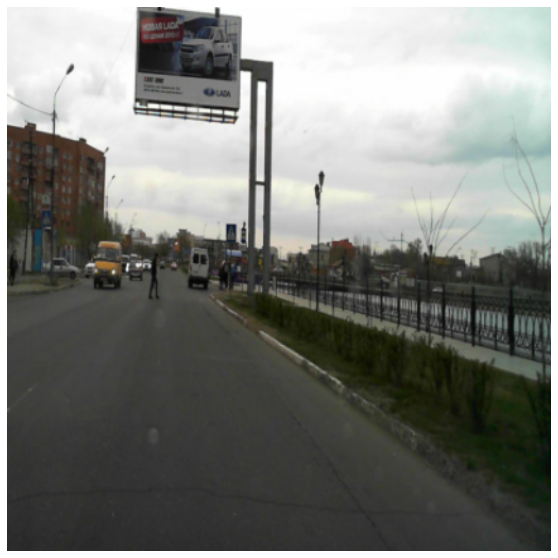

In [18]:
show_tranformed_image(data_loader_train2)

In [ ]:
show_tranformed_image(data_loader_train_2)

### DATASET CLASSIFIC

In [19]:
device_id = -1
device = 'cpu' if device_id == -1 else f'cuda:{device_id}'
n_epochs = 5
batch_size = 6
classes1 = 156
device

'cpu'

#### pandas

In [20]:
class RTSD_dataset_clf_my(Dataset):
    def __init__(self, path_img, df, transforms=None):
        super().__init__()
        self.path_img = path_img
        self.transforms = transforms
        self.df = df
        
    def __getitem__(self, index):
        name_img = self.df.loc[index,'file_name']
        boxes = self.df.loc[index,'bbox']
        bb = [boxes[0], boxes[1], boxes[0] + boxes[2], boxes[1] + boxes[3]]
        imgs = Image.open(os.path.join(self.path_img, name_img))
        imgs = imgs.crop(bb)

        if self.transforms is not None:
            imgs = self.transforms(imgs)

        imgs = imgs / 255

        targets = torch.tensor(self.df.loc[index, 'category_id'])


#         return imgs, targets
        return {
                'images': imgs,
                'targets': targets}
    
    def __len__(self):
        
        return self.df.shape[0]

In [21]:
def get_transform1():
    return transforms.Compose([transforms.Resize((512,512)), transforms.ToTensor()])

In [22]:
def get_transform_a1():
             return transforms.Compose([transforms.Resize((512,512)),
                    transforms.RandomChoice([transforms.Compose([transforms.RandomPerspective(), transforms.ToTensor()]),
                    transforms.Compose([transforms.ColorJitter(), transforms.ToTensor()]),
                    transforms.Compose([transforms.RandomResizedCrop((512,512)),transforms.ToTensor()]),
                    transforms.Compose([transforms.ToTensor(),transforms.RandomErasing()])])])

In [23]:
df12 = RTSD_dataset_clf_my('./', df_train_anno_reduced, transforms=get_transform1())
df112 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform1())
df222 = RTSD_dataset_clf_my('./', df_train_anno_reduced, transforms=get_transform_a1())
df122 = RTSD_dataset_clf_my('./', df_val_anno, transforms=get_transform_a1())

In [24]:
data_loader_train12 = torch.utils.data.DataLoader(df12,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val12 = torch.utils.data.DataLoader(df112,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)
data_loader_train22 = torch.utils.data.DataLoader(df222,
                                          batch_size=batch_size,
                                          shuffle=True, drop_last = True)

data_loader_val22 = torch.utils.data.DataLoader(df122,
                                          batch_size=batch_size,
                                          shuffle=False, drop_last = True)

#### Визуализация аргументации данных

In [25]:
def show_tranformed_image2(train_loader):
    if len(train_loader) > 0:
        for i in range(1):
            data = next(iter(train_loader))
            images, targets = data['images'], data['targets']
            images = list(image.to(device) for image in images)
            sample = images[i].permute(1, 2, 0).detach().cpu().numpy()
            sample = sample * 255
            targets = [t.to(device) for t in targets]
            targets = targets[i].item()
            
            plt.imshow(sample)
            plt.title(targets)
            plt.axis('off')
            plt.show()

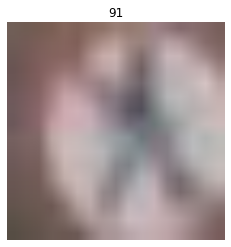

In [26]:
show_tranformed_image2(data_loader_train22)

In [27]:
def show_tranformed_image12(train_loader):
            figure = plt.figure(figsize=(10, 8))
            cols, rows = 3, 3
            if len(train_loader) > 0:
                  for i in range(1, cols * rows + 1):
                              for j in range(1):
                                  data = next(iter(train_loader))
                                  images, targets = data['images'], data['targets']
                                  targets = targets[j].item()
                                  sample = images[j].permute(1, 2, 0).detach().cpu().numpy()
                                  sample = sample * 255
                                  figure.add_subplot(rows, cols, i)
                                                    
                                  plt.imshow(sample)
                                  
                                  plt.title(targets)
                                  plt.axis("off")
            plt.show()

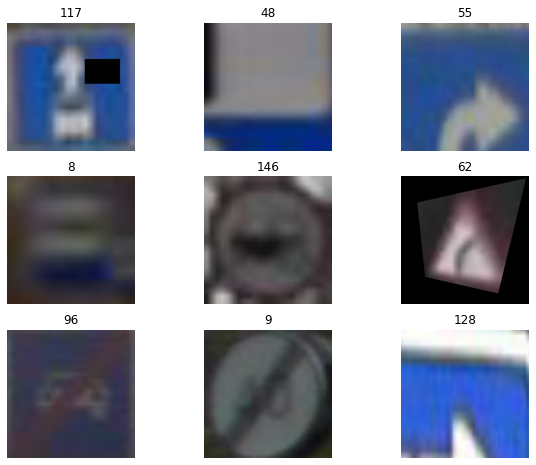

In [28]:
show_tranformed_image12(data_loader_train22)